### Analyzing Portfolio Algorithm using Momentum Strategy

#### Measure the return in the past month for the 30 stocks in the Dow Jones Index, sort them from best to worst performance and buy the top 10. Each stock will be equal weighted and have a weigth of 10%

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.6%
Cumulative returns,295.2%
Annual volatility,18.2%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.2%


/Users/lhon001/Development/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


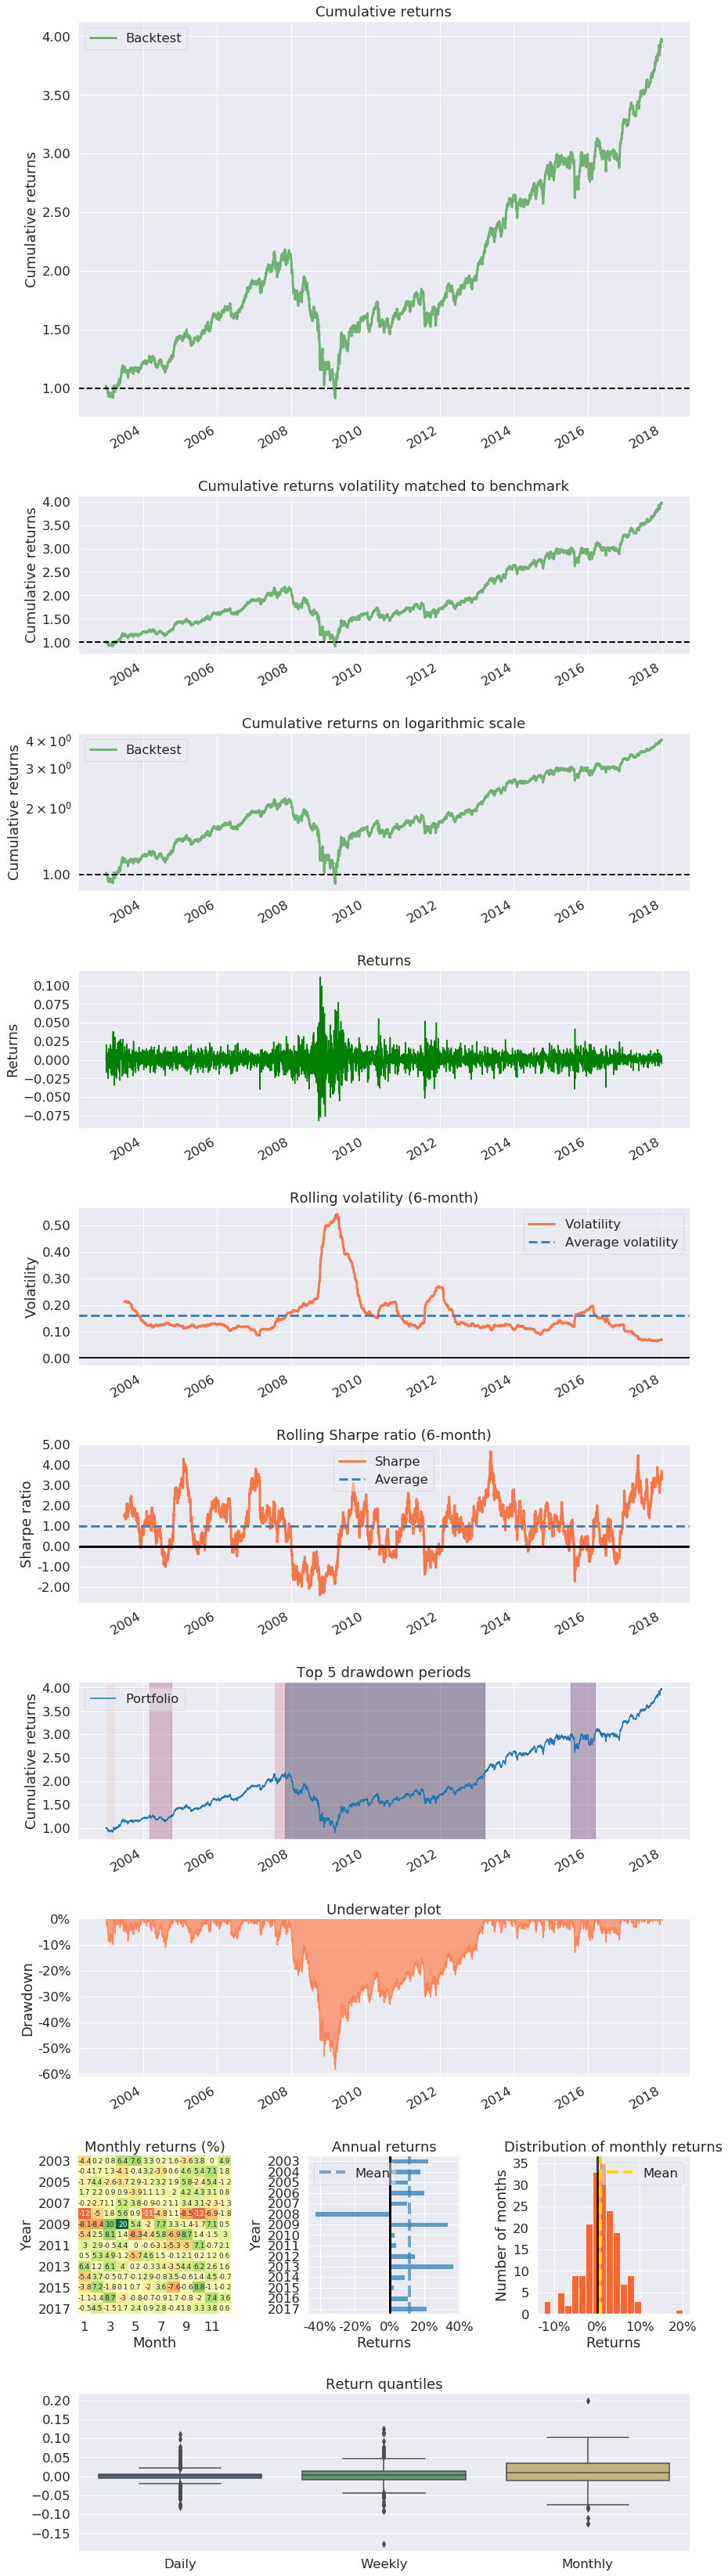

In [1]:
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, \
schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import pyfolio as pf

def initialize(context):
    # Which stocks to trade
    dji = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DWDP",
          "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
          "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "UTX", "V",
          "VZ", "WBA", "WMT", "XOM"]
    
    # Make a list of symbols objects from the list of tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())

# Check the month performance
# Take the last data point and divide by the first data point and subtract 1
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get historical data for all stocks in the data object
    stock_hist = data.history(context.dji_symbols, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order. 
    # Here we are applying the month_perf() function on the stock_hist DataFrame
    perf_table = stock_hist.apply(month_perf).sort_values(ascending=False)
    
    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)
    
    # Make sure we are flat the rest
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off backtest; run_algorithm acturally returns a dataframe
result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)

In [2]:
print(result.head())
# for column in result:
#     print(column)

                           algo_volatility  algorithm_period_return     alpha  \
2003-01-02 00:00:00+00:00              NaN                 0.000000       NaN   
2003-01-03 00:00:00+00:00         0.005758                -0.000513 -0.142921   
2003-01-06 00:00:00+00:00         0.188445                 0.019776  1.584819   
2003-01-07 00:00:00+00:00         0.202427                 0.009602 -0.505895   
2003-01-08 00:00:00+00:00         0.223167                -0.007561 -1.299039   

                           benchmark_period_return  benchmark_volatility  \
2003-01-02 00:00:00+00:00                 0.032189                   NaN   
2003-01-03 00:00:00+00:00                 0.035362              0.326804   
2003-01-06 00:00:00+00:00                 0.053610              0.231085   
2003-01-07 00:00:00+00:00                 0.051003              0.247106   
2003-01-08 00:00:00+00:00                 0.035815              0.287549   

                               beta  capital_used   endi

In [3]:
result.loc['2010-11-17', 'portfolio_value']

15992.004508500006

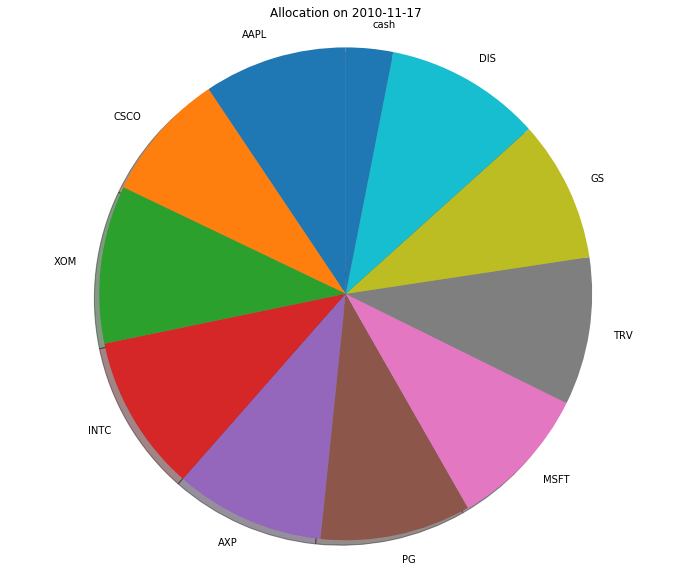

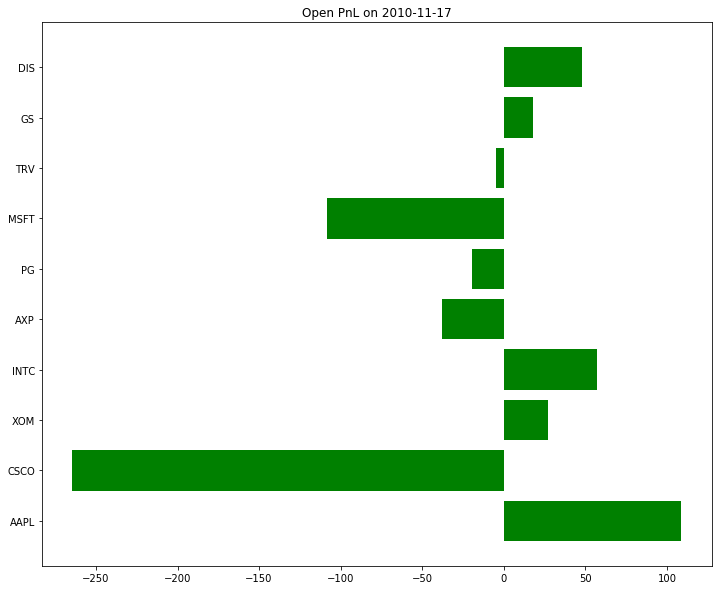

In [4]:
# Sometimes it's helpful to check one or a few days within an equity curve to see
# why a model is behaving the way it is. Let's get a portfolio snapshot

# Select a day to view
day = '2010-11-17'

# Get portfolio value and positions for this day
port_value = result.loc[day,'portfolio_value']
day_positions = result.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pn1'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker, 'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker, 'pnl'] = df.loc[ticker, 'value'] - (pos['amount'] * pos['cost_basis'])
    
# Add cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make a bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh(pnl_df.index, pnl_df['pnl'], align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()